# English to Hausa Translation Model with RNNs and Attention

### This notebook demonstrates the development of an English to Hausa translation model using Recurrent Neural Networks (RNNs) with an attention mechanism. We'll process the provided dataset, build, train, and evaluate the model.

## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, Dropout, Concatenate, Attention, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.15.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Inspect Dataset

In [7]:
# Load the data
data = pd.read_csv('data/parallel-hausa-tweets.csv')

# Display the first few rows
data.head()


,CleanedMainT,CleanedReplyT,Hausa2EngMainT,Hausa2EngReplyT
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Abunda ya faru tun last week,Jurgen Klopp has won the Fifa World Coach of t...,It's been a while since last week
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Ku sai yanzu ku ke sawa news,Jurgen Klopp has won the Fifa World Coach of t...,You are now wearing news
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Allah ya isa tsakaninmu da duk wanda yake da s...,Gunmen kill man and burn sacks of maize in Kaduna,May Allah reach between us and all those who a...
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa innailaihi rajiun. Wannan kasar...,Gunmen kill man and burn sacks of maize in Kaduna,Innalillahi wa innailaihi rajiun. This country...
5,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Subhnallah,Gunmen kill man and burn sacks of maize in Kaduna,Subhnallah


In [8]:
# Display column names
print("Columns:", data.columns.tolist())

# Check for missing values
print("\nMissing values:\n", data.isnull().sum())

# Data information
data.info()


Columns: ['CleanedMainT', 'CleanedReplyT', 'Hausa2EngMainT', 'Hausa2EngReplyT']

Missing values:
 CleanedMainT       0
CleanedReplyT      5
Hausa2EngMainT     0
Hausa2EngReplyT    3
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 104
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CleanedMainT     292 non-null    object
 1   CleanedReplyT    287 non-null    object
 2   Hausa2EngMainT   292 non-null    object
 3   Hausa2EngReplyT  289 non-null    object
dtypes: object(4)
memory usage: 11.4+ KB


## Data Preparation

## Combine Main Texts and Replies

In [10]:
# Create a new DataFrame with combined texts
main_df = data[['CleanedMainT', 'Hausa2EngMainT']].rename(
    columns={'CleanedMainT': 'hausa', 'Hausa2EngMainT': 'english'}
)
reply_df = data[['CleanedReplyT', 'Hausa2EngReplyT']].rename(
    columns={'CleanedReplyT': 'hausa', 'Hausa2EngReplyT': 'english'}
)

# Concatenate the two DataFrames
combined_df = pd.concat([main_df, reply_df], ignore_index=True)

# Drop rows with missing values
combined_df = combined_df.dropna()

# Display the combined data
combined_df.head()


,hausa,english
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Jurgen Klopp has won the Fifa World Coach of t...
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Jurgen Klopp has won the Fifa World Coach of t...
2,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna


## Data Cleaning and Preprocessing

## Define Cleaning Function

In [12]:
def clean_text(text):
    # Convert to string and lowercase
    text = str(text).lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


 ## Apply Cleaning Function and Additional Preprocessing

In [13]:
# Apply the cleaning function
combined_df['hausa_clean'] = combined_df['hausa'].apply(clean_text)
combined_df['english_clean'] = combined_df['english'].apply(clean_text)


## Remove Stopwords and Apply Lemmatization

In [17]:
# Initialize stopwords and lemmatizer
stop_words_hausa = set()  # Assuming Hausa stopwords are not readily available
stop_words_english = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, stop_words):
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply preprocessing
combined_df['hausa_clean'] = combined_df['hausa_clean'].apply(lambda x: preprocess_text(x, stop_words_hausa))
combined_df['english_clean'] = combined_df['english_clean'].apply(lambda x: preprocess_text(x, stop_words_english))


In [ ]:
## Remove Empty Strings

In [18]:
# Remove empty strings
combined_df = combined_df[
    (combined_df['hausa_clean'].str.len() > 0) &
    (combined_df['english_clean'].str.len() > 0)
]

# Display cleaned data
combined_df[['hausa_clean', 'english_clean']].head()


,hausa_clean,english_clean
0,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp fifa world coach year award
1,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp fifa world coach year award
2,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunman kill man burn sack maize kaduna
3,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunman kill man burn sack maize kaduna
4,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunman kill man burn sack maize kaduna


In [19]:
print(f"Total samples after cleaning: {len(combined_df)}")


Total samples after cleaning: 575


## Exploratory Data Analysis (EDA)

## Word Cloud Visualization

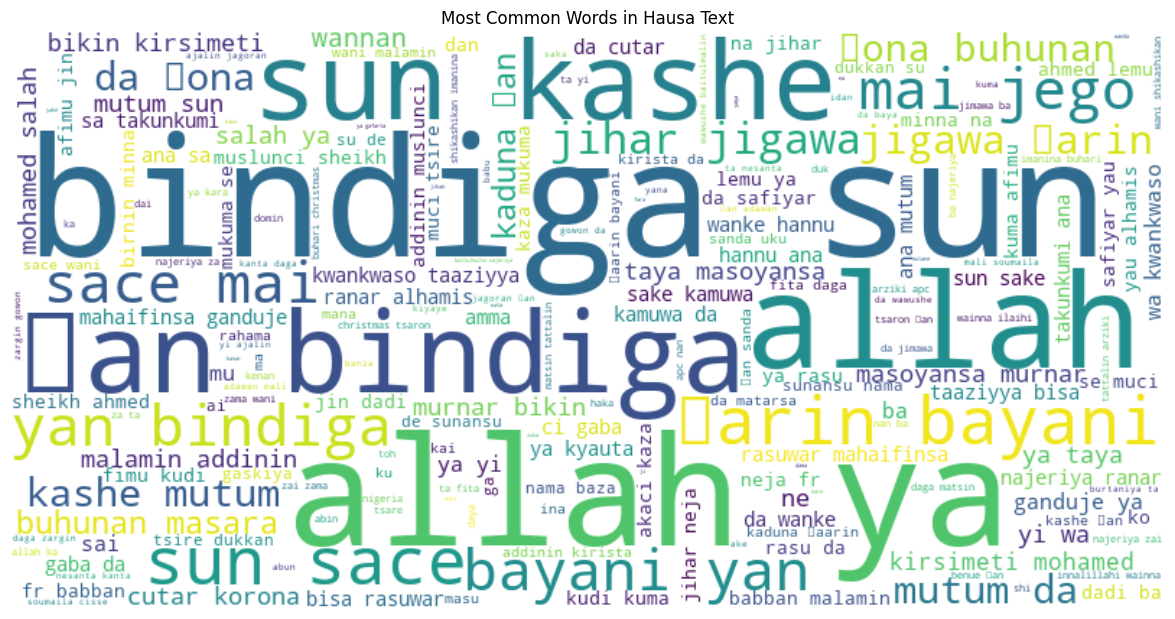

In [20]:
# Combine all Hausa text
hausa_text = ' '.join(combined_df['hausa_clean'])

# Generate word cloud for Hausa text
wordcloud_hausa = WordCloud(width=800, height=400, background_color='white').generate(hausa_text)

# Display the generated image
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_hausa, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Hausa Text')
plt.show()


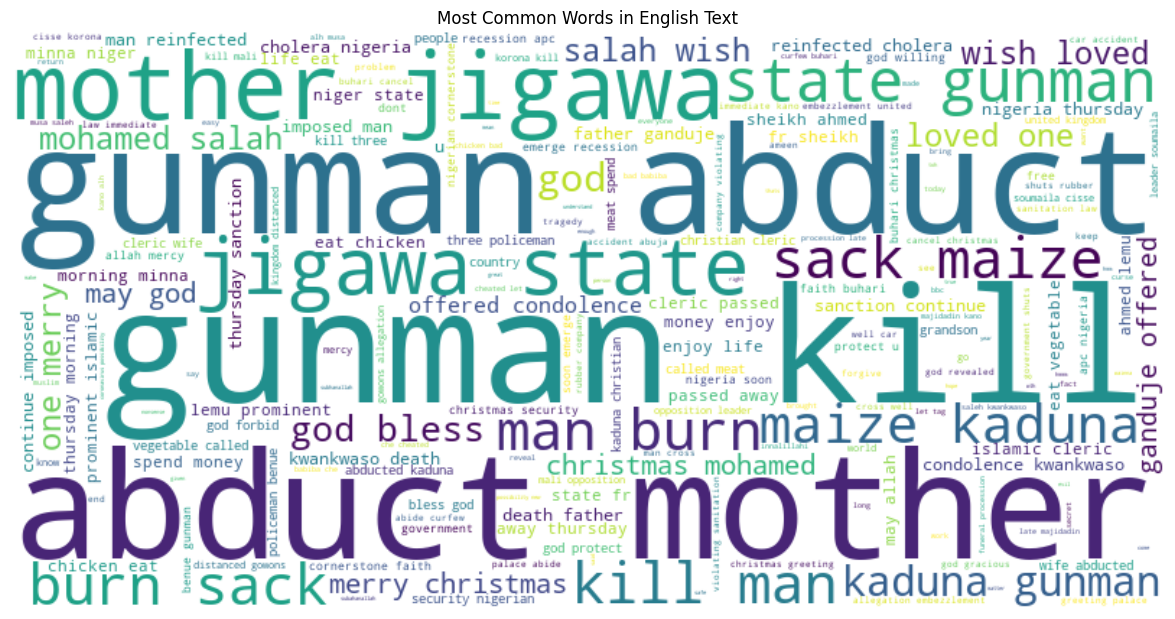

In [21]:
# Combine all English text
english_text = ' '.join(combined_df['english_clean'])

# Generate word cloud for English text
wordcloud_english = WordCloud(width=800, height=400, background_color='white').generate(english_text)

# Display the generated image
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_english, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in English Text')
plt.show()


## Frequency Distribution Plots

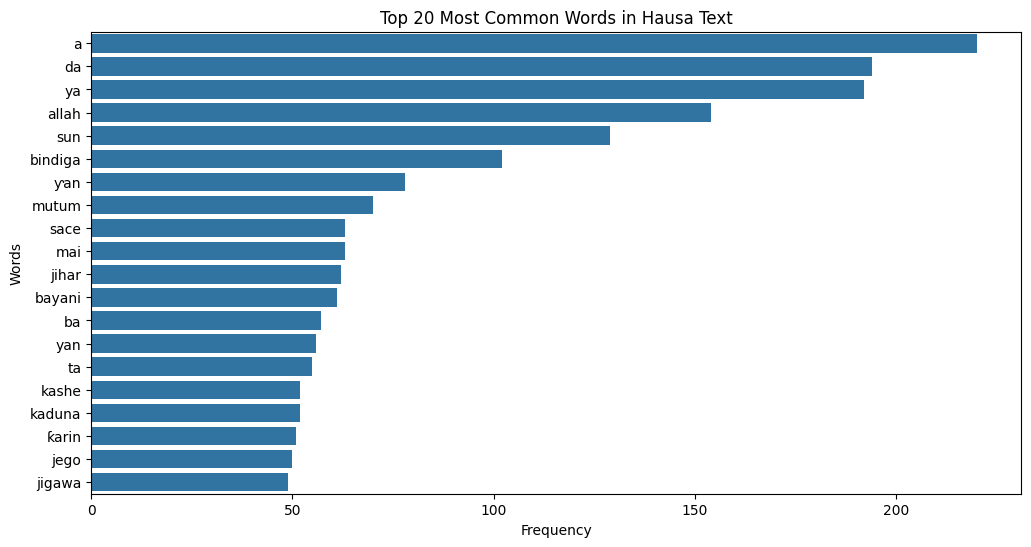

In [22]:
from nltk.probability import FreqDist

# For Hausa text
all_words_hausa = hausa_text.split()
fdist_hausa = FreqDist(all_words_hausa)
common_words_hausa = fdist_hausa.most_common(20)

words_hausa = [word for word, count in common_words_hausa]
counts_hausa = [count for word, count in common_words_hausa]

plt.figure(figsize=(12, 6))
sns.barplot(x=counts_hausa, y=words_hausa)
plt.title('Top 20 Most Common Words in Hausa Text')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


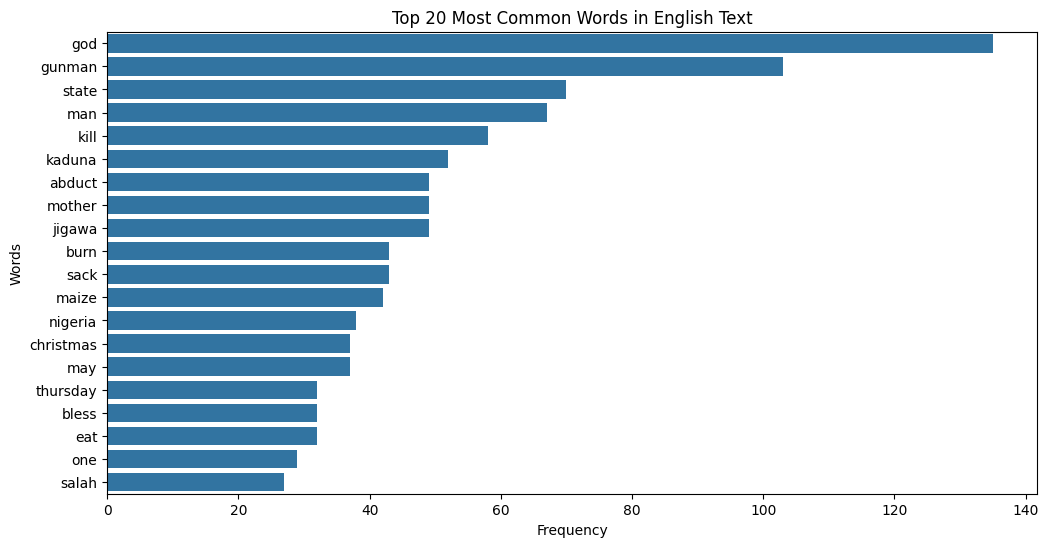

In [23]:
# For English text
all_words_english = english_text.split()
fdist_english = FreqDist(all_words_english)
common_words_english = fdist_english.most_common(20)

words_english = [word for word, count in common_words_english]
counts_english = [count for word, count in common_words_english]

plt.figure(figsize=(12, 6))
sns.barplot(x=counts_english, y=words_english)
plt.title('Top 20 Most Common Words in English Text')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


## Tokenization and Sequence Padding

## Prepare Texts and Add Tokens

In [24]:
# Prepare input and target texts
input_texts = combined_df['hausa_clean'].tolist()
target_texts = combined_df['english_clean'].tolist()

# Add start and end tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]


## Tokenize the Texts

In [25]:
# Tokenizer for input language (Hausa)
input_tokenizer = Tokenizer(filters='', lower=False)
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_word_index = input_tokenizer.word_index
num_encoder_tokens = len(input_word_index) + 1  # +1 for padding token

# Tokenizer for target language (English)
target_tokenizer = Tokenizer(filters='', lower=False)
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_word_index = target_tokenizer.word_index
num_decoder_tokens = len(target_word_index) + 1  # +1 for padding token


## Determine Maximum Sequence Lengths

In [26]:
max_encoder_seq_length = max(len(seq) for seq in input_sequences)
max_decoder_seq_length = max(len(seq) for seq in target_sequences)

print(f"Number of samples: {len(input_texts)}")
print(f"Number of unique input tokens: {num_encoder_tokens}")
print(f"Number of unique output tokens: {num_decoder_tokens}")
print(f"Max sequence length for inputs: {max_encoder_seq_length}")
print(f"Max sequence length for outputs: {max_decoder_seq_length}")


Number of samples: 575
Number of unique input tokens: 1250
Number of unique output tokens: 830
Max sequence length for inputs: 24
Max sequence length for outputs: 18


## Pad the Sequences

In [27]:
# Pad input sequences
encoder_input_data = pad_sequences(
    input_sequences, maxlen=max_encoder_seq_length, padding='post'
)

# Pad target sequences
decoder_input_data = pad_sequences(
    target_sequences, maxlen=max_decoder_seq_length, padding='post'
)


## Create Decoder Target Data

In [28]:
# Prepare decoder target data
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, 0:-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # Padding token


## Train-Test Split

In [30]:
# Create an array of indices
data_indices = np.arange(len(input_texts))

# Perform the train-test split, including the indices
(
    encoder_input_train, encoder_input_val,
    decoder_input_train, decoder_input_val,
    decoder_target_train, decoder_target_val,
    train_indices, val_indices
) = train_test_split(
    encoder_input_data,
    decoder_input_data,
    decoder_target_data,
    data_indices,
    test_size=0.1,
    random_state=42
)


## Model Building with Attention

# Set Hyperparameters

In [31]:
embedding_dim = 256
lstm_units = 512


## Define Encoder and Decoder Functions

## Encoder Function

In [52]:
def build_encoder(num_encoder_tokens, embedding_dim, lstm_units):
    encoder_inputs = Input(shape=(None,), name='encoder_inputs')
    encoder_embedding_layer = Embedding(
        input_dim=num_encoder_tokens, output_dim=embedding_dim, name='encoder_embedding'
    )
    encoder_embedding = encoder_embedding_layer(encoder_inputs)
    encoder_embedding = Dropout(0.2)(encoder_embedding)
    
    # Bidirectional LSTM
    encoder_lstm = Bidirectional(LSTM(
        lstm_units, return_sequences=True, return_state=True, name='encoder_lstm'
    ))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    return encoder_inputs, encoder_outputs, encoder_states, encoder_embedding_layer


## Decoder Function


In [53]:
def build_decoder(num_decoder_tokens, embedding_dim, lstm_units, encoder_states):
    decoder_inputs = Input(shape=(None,), name='decoder_inputs')
    decoder_embedding_layer = Embedding(
        input_dim=num_decoder_tokens, output_dim=embedding_dim, name='decoder_embedding'
    )
    decoder_embedding = decoder_embedding_layer(decoder_inputs)
    decoder_embedding = Dropout(0.2)(decoder_embedding)
    
    decoder_lstm = LSTM(
        lstm_units * 2, return_sequences=True, return_state=True, name='decoder_lstm'
    )
    decoder_outputs, _, _ = decoder_lstm(
        decoder_embedding, initial_state=encoder_states
    )
    
    return decoder_inputs, decoder_outputs, decoder_embedding_layer, decoder_lstm


## Build the Model

In [54]:
# Build Encoder
encoder_inputs, encoder_outputs, encoder_states, encoder_embedding_layer = build_encoder(
    num_encoder_tokens, embedding_dim, lstm_units
)

# Build Decoder
decoder_inputs, decoder_outputs, decoder_embedding_layer, decoder_lstm = build_decoder(
    num_decoder_tokens, embedding_dim, lstm_units, encoder_states
)

from tensorflow.keras.layers import Dot, Activation

# Compute the attention scores
attention_scores = Dot(axes=[2, 2], name='attention_scores')([decoder_outputs, encoder_outputs])

# Apply softmax to get the attention weights
attention_weights = Activation('softmax', name='attention_weights')(attention_scores)

# Compute the context vector as the weighted sum of the encoder outputs
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, encoder_outputs])

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')([context_vector, decoder_outputs])

# Final output layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_combined_context)


## Build and Compile the Model

In [55]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

# Summary of the model
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  


 encoder_embedding (Embeddi  (None, None, 256)            320000    ['encoder_inputs[0][0]']      
 ng)                                                                                              
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 dropout_3 (Dropout)         (None, None, 256)            0         ['encoder_embedding[0][0]']   
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 256)            212480    ['decoder_inputs[0][0]']      
 ng)                                                                                              
          

## Model Training

## Prepare Target Data

In [56]:
# Reshape decoder target data to be compatible with sparse_categorical_crossentropy
decoder_target_train = decoder_target_train.reshape(
    *decoder_target_train.shape, 1
)
decoder_target_val = decoder_target_val.reshape(
    *decoder_target_val.shape, 1
)


## Define Early Stopping Callback

In [57]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


## Train the Model

In [58]:
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    batch_size=64,
    epochs=50,
    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
    callbacks=[early_stopping]
)


Epoch 1/50
9/9 [==============================] - 10s 672ms/step - loss: 4.2075 - accuracy: 0.5589 - val_loss: 2.6827 - val_accuracy: 0.6255
Epoch 2/50
9/9 [==============================] - 6s 716ms/step - loss: 2.3491 - accuracy: 0.6364 - val_loss: 2.2716 - val_accuracy: 0.6312
Epoch 3/50
9/9 [==============================] - 7s 781ms/step - loss: 2.1059 - accuracy: 0.6426 - val_loss: 2.1872 - val_accuracy: 0.6446
Epoch 4/50
9/9 [==============================] - 7s 731ms/step - loss: 1.9667 - accuracy: 0.6541 - val_loss: 2.0900 - val_accuracy: 0.6494
Epoch 5/50
9/9 [==============================] - 7s 826ms/step - loss: 1.8554 - accuracy: 0.6570 - val_loss: 2.0291 - val_accuracy: 0.6446
Epoch 6/50
9/9 [==============================] - 7s 821ms/step - loss: 1.7600 - accuracy: 0.6811 - val_loss: 1.9963 - val_accuracy: 0.6571
Epoch 7/50
9/9 [==============================] - 7s 795ms/step - loss: 1.6952 - accuracy: 0.6933 - val_loss: 1.9445 - val_accuracy: 0.6762
Epoch 8/50
9/9 [===

## Plot Training History

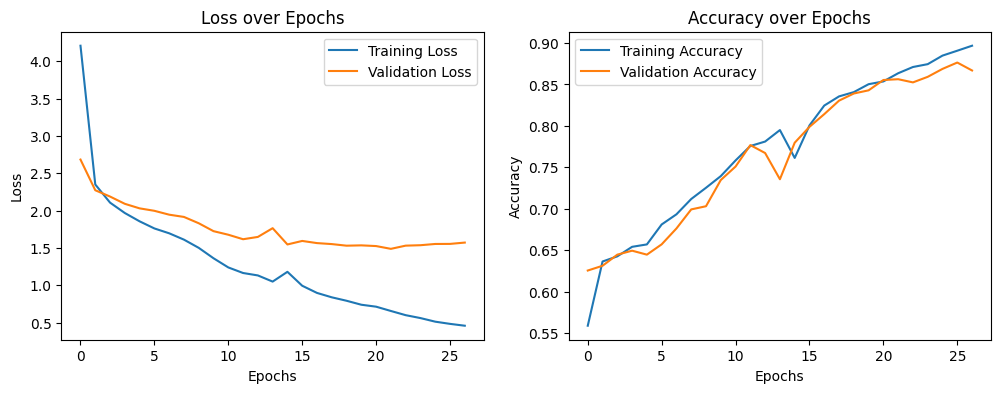

In [59]:
def plot_training_history(history):
    # Loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)


 ## Model Evaluation

 ## Build Inference Models

## Encoder Model for Inference

In [60]:
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states[0], encoder_states[1]])


## Decoder Model for Inference

In [61]:
# Decoder inputs for inference
decoder_state_input_h = Input(
    shape=(lstm_units * 2,), name='decoder_state_input_h'
)
decoder_state_input_c = Input(
    shape=(lstm_units * 2,), name='decoder_state_input_c'
)
decoder_hidden_state_input = Input(
    shape=(None, lstm_units * 2), name='encoder_outputs'
)

# Use the same embedding layer as in training
dec_emb2 = decoder_embedding_layer(decoder_inputs)
dec_emb2 = Dropout(0.2)(dec_emb2)  # Apply dropout if used in training

# Set initial states to states from previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Compute the attention scores
attention_scores = Dot(axes=[2, 2], name='attention_scores')([decoder_outputs2, decoder_hidden_state_input])

# Apply softmax to get the attention weights
attention_weights = Activation('softmax', name='attention_weights')(attention_scores)

# Compute the context vector
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, decoder_hidden_state_input])

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')([context_vector, decoder_outputs2])

# Final output layer
decoder_outputs2 = decoder_dense(decoder_combined_context)

# Final decoder model that outputs attention weights
decoder_model = Model(
    [
        decoder_inputs,
        decoder_hidden_state_input,
        decoder_state_input_h,
        decoder_state_input_c
    ],
    [decoder_outputs2, state_h2, state_c2, attention_weights]
)


## Create Reverse Word Index

In [62]:
reverse_input_word_index = {
    i: word for word, i in input_word_index.items()
}
reverse_target_word_index = {
    i: word for word, i in target_word_index.items()
}
target_word_index = target_tokenizer.word_index


## Define Decoding Function with Attention Weights

In [63]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    encoder_outputs_val, state_h_val, state_c_val = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1 with only the start token
    target_seq = np.array([[target_word_index['<start>']]])

    # Initialize variables
    stop_condition = False
    decoded_sentence = ''
    attention_weights_list = []

    while not stop_condition:
        output_tokens, h, c, attention_weights = decoder_model.predict(
            [target_seq, encoder_outputs_val, state_h_val, state_c_val]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index.get(sampled_token_index, '')

        # Save attention weights
        attention_weights_list.append(attention_weights[0, 0, :len(input_seq[0])])

        # Exit condition: either hit max length or find stop token
        if (sampled_word == '<end>' or len(decoded_sentence.split()) >= max_decoder_seq_length):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence (length 1)
        target_seq = np.array([[sampled_token_index]])

        # Update states
        state_h_val, state_c_val = h, c

    return decoded_sentence.strip(), attention_weights_list


## Evaluate the Model

In [69]:
for idx in range(10):
    # Get the actual index in the original data
    val_idx = val_indices[idx]
    
    # Take one sequence from the validation set
    input_seq = encoder_input_val[idx:idx+1]
    decoded_sentence, _ = decode_sequence(input_seq)
    
    # Get the corresponding input sentence and actual translation
    input_sentence = input_texts[val_idx]
    actual_translation = target_texts[val_idx][8:-6]  # Remove <start> and <end>
    
    print(f"Input (Hausa): {input_sentence}")
    print(f"Actual Translation: {actual_translation}")
    print(f"Predicted Translation: {decoded_sentence}")
    print("-" * 50)


1/1 [==============================] - 0s 20ms/step
Input (Hausa): buhari ya soke ziyarar gaisuwar kirsimeti zuwa fadarsa don kiyaye dokokin hana yaduwar cutar korona…
Actual Translation: buhari cancel christmas greeting palace abide curfew
Predicted Translation: christian cleric wife recession apc
--------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Input (Hausa): mohamed salah ya taya masoyansa murnar bikin kirsimeti
Actual Translation: mohamed salah wish loved one merry christmas
Predicted Translation: mohamed salah wish loved one merry christmas
--------------------------------------------------
1/1 [==============================] - 0s 23ms/step
Input (Hausa): yan bindiga sun sace mai jego a jihar jigawa ƙarin bayani
Actual Translation: gunman abduct mother jigawa state
Predicted Translation: gunman abduct mother jigawa state
--------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Inpu

## Visualizing Attention Weights

## Define Function to Plot Attention Weights

In [66]:
def plot_attention(attention_weights, input_sentence, translated_sentence):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Convert attention weights to a 2D array
    attention_matrix = np.array(attention_weights)

    # Plotting attention weights using seaborn
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        attention_matrix,
        xticklabels=input_sentence.split(),
        yticklabels=translated_sentence.split(),
        cmap='viridis',
        ax=ax
    )
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights')
    plt.show()


## Visualize Attention for a Sample

1/1 [==============================] - 0s 24ms/step
Input (Hausa): buhari ya soke ziyarar gaisuwar kirsimeti zuwa fadarsa don kiyaye dokokin hana yaduwar cutar korona…
Actual Translation: buhari cancel christmas greeting palace abide curfew
Predicted Translation: christian cleric wife recession apc


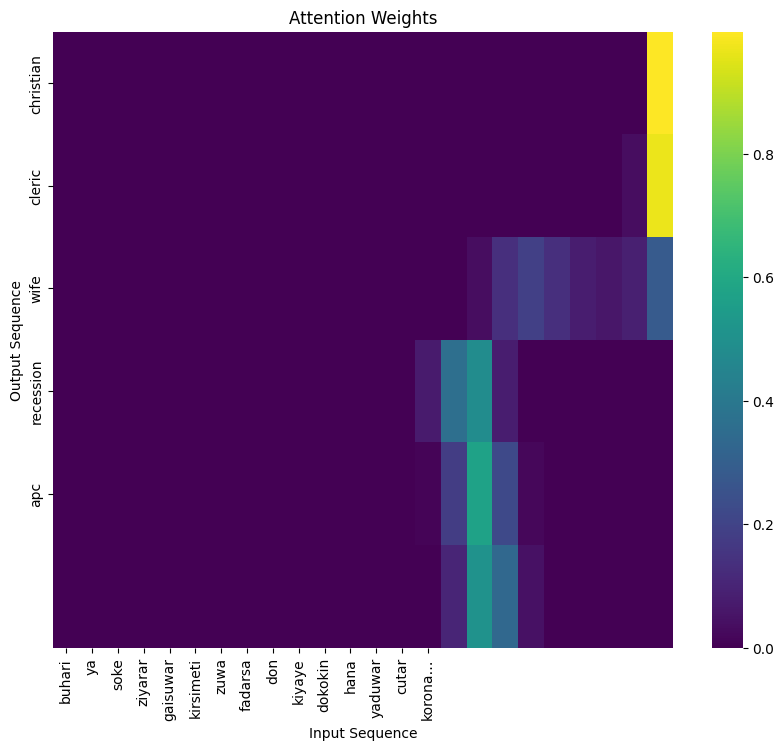

In [67]:
# Take one sequence from the validation set
input_seq = encoder_input_val[0:1]
decoded_sentence, attention_weights = decode_sequence(input_seq)

# Get the corresponding input sentence and actual translation
val_idx = val_indices[0]
input_sentence = input_texts[val_idx]
actual_translation = target_texts[val_idx][8:-6]  # Remove <start> and <end>

print(f"Input (Hausa): {input_sentence}")
print(f"Actual Translation: {actual_translation}")
print(f"Predicted Translation: {decoded_sentence}")

# Plot attention weights
plot_attention(attention_weights, input_sentence, decoded_sentence)


## Word Embedding Visualization

## Visualize Word Embeddings Using PCA

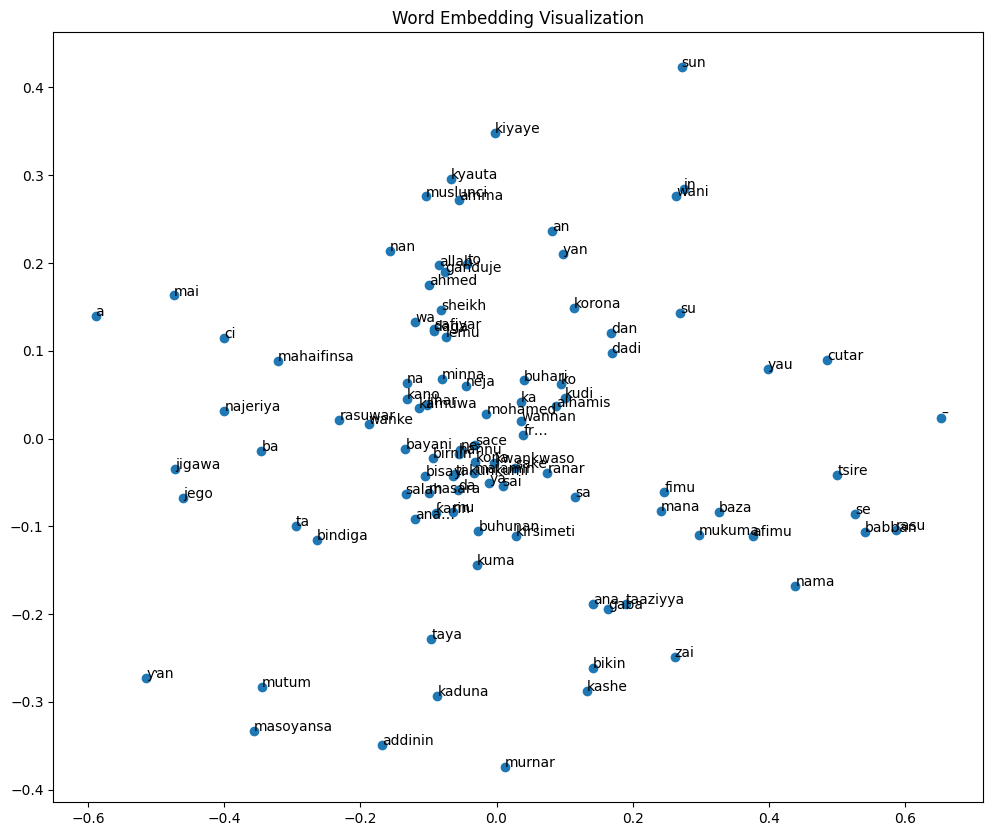

In [68]:
def visualize_word_embeddings(embedding_layer, word_index, num_words=100):
    weights = embedding_layer.get_weights()[0]
    words = list(word_index.keys())[:num_words]
    embeddings = weights[:num_words]
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    
    for i, word in enumerate(words):
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    
    plt.title('Word Embedding Visualization')
    plt.show()

# Visualize Hausa embeddings
visualize_word_embeddings(encoder_embedding_layer, input_word_index)
